In [0]:
import gc
import sys
from PIL import Image
from glob import glob 
import zipfile
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import os
from tqdm import tqdm_notebook,trange,tqdm
import matplotlib.pyplot as plt


import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F


In [0]:
################################using kaggle api to download data directly from kaggle########################################
# # Install kaggle packages
# !pip install -q kaggle
# !pip install -q kaggle-cli
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions download -c histopathologic-cancer-detection

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/MDSBA/DL1/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# # ##################################code to unzip the zipfiles containing resized images########################################
# zip_ref1 = zipfile.ZipFile("/content/drive/My Drive/MDSBA/DL1/histopathologic-cancer-detection.zip", 'r')
# zip_ref1.extractall("/content/drive/My Drive/MDSBA/DL1/")
# zip_ref1.close()

Here, we create a dataframe with columns path (folder path of the image), id (image id name extracted from the path) and label(output which needs to be predicted).

In [0]:
# path = "C:/Users/oshee/Documents/MDSBA/T2/Deep Learning/project/histopathologic-cancer-detection/" 
path = "/content/drive/My Drive/MDSBA/DL1/" 
train_path = path + 'train/'
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
#print(df.head())
df['id'] = df.path.map(lambda x: x.split('train/')[1].split(".")[0]) 
#print(df)
labels = pd.read_csv(path+"train_labels.csv") 
df = df.merge(labels, on = "id") 
print(df.head()) 

,Unnamed: 0,path,id,label
0,0,/content/drive/My Drive/MDSBA/DL1/train/37afd9...,37afd9cc095b853a51e4df9d91f04458a97e7fee,0
1,1,/content/drive/My Drive/MDSBA/DL1/train/37affb...,37affbb431561644aa55962f8974525c9f3c2abf,0
2,2,/content/drive/My Drive/MDSBA/DL1/train/37b03c...,37b03ce938e7b15da59524ff05be6321d551ddaa,0
3,3,/content/drive/My Drive/MDSBA/DL1/train/37b13e...,37b13ed76cbd6f216197b379f30ff39e1101f10e,0
4,4,/content/drive/My Drive/MDSBA/DL1/train/37b184...,37b18467265c86e02901252b5a2d68d10722f53c,0


In [0]:
df.to_csv('/content/drive/My Drive/MDSBA/DL1/df.csv')

In [0]:
df = pd.read_csv('/content/drive/My Drive/MDSBA/DL1/df.csv')

# **PRE-TRAINED MODELS** 
Now we are going to experiment with 3 pre-trained models. We are going to use the models VGG16, Resnet50 and Densenet169 as base models to build deep learning models which can be used for histopathologic cancer detection

In [0]:
##########################function to load data, transform them and convert into tensors##############################
def load_data_pretrained(N,df,transform):
    """ This functions loads N images using the data df
    """
    X = torch.zeros(N,3,224,224) 
    y = torch.tensor(np.squeeze(df.label.values)[0:N])
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        print(row)
        if i == N:
            print('break')
            break
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        X[i] = transform(img) #applies the transform on the image
        #image_new = transform(img) 
        #X[i] = image_new.cpu().data.numpy()
    return X,y

In [0]:
transform_ = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(), #converts image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) #normaizes the image
    ])

X stores the input data and y stores the output data which is the labels. Here, we are loading only 10000 images which is 4.5% of the dataset.


In [0]:
N=10000
#loading data into X and y for 10000 images. 
X,y = load_data_pretrained(N=N,df=df,transform=transform_) 

In [0]:
torch.save(X, '/content/drive/My Drive/MDSBA/DL1/X.pt')
torch.save(y, '/content/drive/My Drive/MDSBA/DL1/y.pt')

In [0]:
X1 = torch.load('/content/drive/My Drive/MDSBA/DL1/X.pt')
y1 = torch.load('/content/drive/My Drive/MDSBA/DL1/y.pt')

In [0]:
gc.collect()
#X_train_tensor = torch.tensor(X)
#Y_train_tensor = torch.tensor(y)
#full_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
#creating tensor dataset
full_dataset = torch.utils.data.TensorDataset(X1, y1)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
#splitting data into train and test
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])
#creating dataloaders
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                           shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32,
                                           shuffle=False)

Below function trains and validates the data. Loss_train and loss_eval contains the train loss and validation loss respectively for each epochs. 

In [0]:
def train_and_val(model, epochs, optimizer, criterion, scheduler):  
    loss_train = []
    loss_eval = []

    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

        #training
        training_loss = 0.0
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            training_loss += loss.item() #* inputs.size(0)
            # if i % 200 == 199:    # print every 200 mini-batches
            #     print('[%d, %5d] loss: %.3f' %
            #           (epoch + 1, i + 1, training_loss / 200))
        loss_train.append(training_loss/len(train_set))
        #validation
        eval_loss = 0.0
        correct = 0.0
        total = 0
        model.eval()
        for i, data in enumerate(val_dataloader, 0):
            images, label = data
            images, label = images.to(device), label.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
            loss = criterion(output, label)
            eval_loss += loss.item() 
            # if i % 200 == 199:    # print every 200 mini-batches
            #     print('[%d, %5d] loss: %.3f' %
            #           (epoch + 1, i + 1, eval_loss / 200))
        loss_eval.append(eval_loss/len(val_set))
        scheduler.step(eval_loss) #for reducing learning rate if necessary 
        print('Accuracy of the network on the test images: %d %%' % float(100 * float(correct) / float(total)))
    print('Finished Training')
    plt.plot(loss_train,label='train')
    plt.plot(loss_eval,label='val')
    plt.legend()
    plt.show()

### VGG16

In [0]:
class VGG_new(nn.Module):
    def __init__(self):
        super(VGG_new, self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.fc1 = nn.Linear(1000, 250)
        self.fc2 = nn.Linear(250, 50)
        self.dropout = nn.Dropout(0.2)
        # self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [0]:
model_vgg = VGG_new()

#freeing the pre-trained model layers
for name, param in model_vgg.named_parameters():
    if name in ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']:
        param.requires_grad = True
    else:
        param.requires_grad = False
device = torch.device('cuda:0')
model_vgg = model_vgg.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
epochs = 10







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:28<04:20, 28.98s/it]

Accuracy of the network on the test images: 81 %








 20%|██        | 2/10 [00:57<03:51, 28.97s/it]

Accuracy of the network on the test images: 81 %








 30%|███       | 3/10 [01:26<03:22, 28.96s/it]

Accuracy of the network on the test images: 82 %








 40%|████      | 4/10 [01:55<02:53, 28.96s/it]

Accuracy of the network on the test images: 82 %








 50%|█████     | 5/10 [02:24<02:24, 28.95s/it]

Accuracy of the network on the test images: 83 %








 60%|██████    | 6/10 [02:53<01:55, 28.95s/it]

Accuracy of the network on the test images: 82 %








 70%|███████   | 7/10 [03:22<01:26, 28.95s/it]

Accuracy of the network on the test images: 83 %








 80%|████████  | 8/10 [03:51<00:57, 28.96s/it]

Accuracy of the network on the test images: 80 %








 90%|█████████ | 9/10 [04:20<00:28, 28.96s/it]

Accuracy of the network on the test images: 82 %








100%|██████████| 10/10 [04:49<00:00, 28.95s/it]

Accuracy of the network on the test images: 83 %
Finished Training


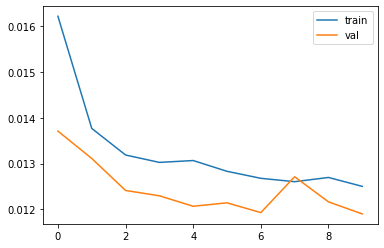

In [0]:
train_and_val(model=model_vgg, epochs=epochs, optimizer=optimizer, criterion=criterion, scheduler=scheduler)

### **MODEL 3 - Resnet**

In [0]:
class Resnet_new(nn.Module):
    def __init__(self):
        super(Resnet_new, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.fc1 = nn.Linear(1000, 250)
        self.fc2 = nn.Linear(250, 50)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [0]:
model_resnet = Resnet_new()
#freeing the pre-trained model layers
for name, param in model_resnet.named_parameters():
    if name in ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']:
        param.requires_grad = True
    else:
        param.requires_grad = False


device = torch.device('cuda:0')
model_resnet = model_resnet.cuda()


#the best optimizer was found to be adams optimizer, the best loss function was found to be cross entrop loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
epochs = 10







  0%|          | 0/10 [00:00<?, ?it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 59








 10%|█         | 1/10 [00:19<02:54, 19.37s/it]

Accuracy of the network on the test images: 84 %








 20%|██        | 2/10 [00:38<02:34, 19.35s/it]

Accuracy of the network on the test images: 84 %








 30%|███       | 3/10 [00:58<02:15, 19.34s/it]

Accuracy of the network on the test images: 84 %








 40%|████      | 4/10 [01:17<01:56, 19.34s/it]

Accuracy of the network on the test images: 85 %








 50%|█████     | 5/10 [01:36<01:36, 19.33s/it]

Accuracy of the network on the test images: 84 %








 60%|██████    | 6/10 [01:55<01:17, 19.33s/it]

Accuracy of the network on the test images: 85 %








 70%|███████   | 7/10 [02:15<00:57, 19.33s/it]

Accuracy of the network on the test images: 85 %








 80%|████████  | 8/10 [02:34<00:38, 19.33s/it]

Accuracy of the network on the test images: 85 %








 90%|█████████ | 9/10 [02:53<00:19, 19.33s/it]

Accuracy of the network on the test images: 85 %








100%|██████████| 10/10 [03:13<00:00, 19.33s/it]

Accuracy of the network on the test images: 85 %
Finished Training


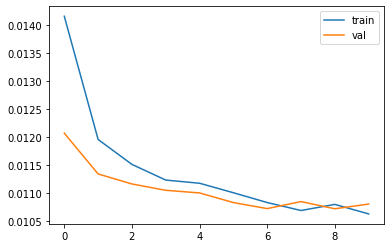

In [0]:
train_and_val(model=model_resnet, epochs=epochs, optimizer=optimizer, criterion=criterion, scheduler=scheduler)

### Densenet

In [0]:
class Densenet_new(nn.Module):
    def __init__(self):
        super(Densenet_new, self).__init__()
        self.model = models.densenet169(pretrained=True)
        self.fc1 = nn.Linear(1000, 250)
        self.fc2 = nn.Linear(250, 50)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [0]:
model_densenet = Densenet_new()
#freeing the pre-trained model layers
for name, param in model_densenet.named_parameters():
    if name in ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']:
        param.requires_grad = True
    else:
        param.requires_grad = False


device = torch.device('cuda:0')
model_densenet = model_densenet.cuda()


#the best optimizer was found to be adams optimizer, the best loss function was found to be cross entrop loss
criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model_densenet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
epochs = 10

 10%|█         | 1/10 [00:26<04:00, 26.68s/it]

Accuracy of the network on the test images: 86 %


 20%|██        | 2/10 [00:52<03:32, 26.53s/it]

Accuracy of the network on the test images: 85 %


 30%|███       | 3/10 [01:19<03:05, 26.43s/it]

Accuracy of the network on the test images: 85 %


 40%|████      | 4/10 [01:45<02:38, 26.37s/it]

Accuracy of the network on the test images: 86 %


 50%|█████     | 5/10 [02:11<02:11, 26.32s/it]

Accuracy of the network on the test images: 86 %


 60%|██████    | 6/10 [02:37<01:45, 26.29s/it]

Accuracy of the network on the test images: 85 %


 70%|███████   | 7/10 [03:03<01:18, 26.27s/it]

Accuracy of the network on the test images: 86 %


 80%|████████  | 8/10 [03:30<00:52, 26.25s/it]

Accuracy of the network on the test images: 86 %


 90%|█████████ | 9/10 [03:56<00:26, 26.24s/it]

Accuracy of the network on the test images: 85 %


100%|██████████| 10/10 [04:22<00:00, 26.26s/it]

Accuracy of the network on the test images: 86 %
Finished Training


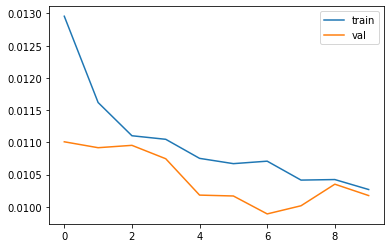

In [13]:
train_and_val(model=model_densenet, epochs=epochs, optimizer=optimizer, criterion=criterion, scheduler=scheduler)